In [2]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
from LightEnv2 import LightEnv2 #Change this to wherever LightEnv module is kept

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 2: Let There Be Light!"

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion
class LightEnvWrapperRandom(gym.Env, LightEnv2):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.torch_collected = False
        self.torch_collected_count = []
        self.mygame = LightEnv2
        self.steps_taken = 0
        #The action space is a choice of 4 actions: U/D/L/R.
        self.action_space = Discrete(4)
        
        #The observation space is a fixed image of the current game screen
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
    def reset(self):
        print("resetting in wrapper")
        
        if self.torch_collected == 1:
            print("Torch was collected this episode!")
        else:
            print("Torch was not collected this episode...")
        self.torch_collected_count.append(self.torch_collected)
        print(self.torch_collected_count)

        self.render(self)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        self.mygame.on_draw(self)
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
        self.steps_taken = 0
        return obs

    def step(self, action):
        self.steps_taken += 1
        
        #Making sure an action is chosen, either: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
#         print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
#         print("env rendered")
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done, torch_collected, fps_check = self.mygame.step(self,actions_myenv)
        if torch_collected == True:
            self.torch_collected = 1
        else:
            self.torch_collected = 0
                    
        if self.steps_taken % 100 == 0: #33 steps roughly equates to 1 second in game time
            print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
            print(f"steps taken: {self.steps_taken}")
#             print(f"FPS is currently: {fps_check}")
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            print(f"steps taken: {self.steps_taken}")
            obs.show()
            self.reset()
        
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #resizing and converting to array for rllib processing
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
        return obsarray
    
    def render(self, mode='state_pixels'):
#         self.mygame.update(self)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)

In [3]:
batch_size = 400
num_iterations = []
score_recorded = []
testing = LightEnvWrapperRandom()
for iterations in range(100): #Calculate range to be same as PPO wrapper based on num steps taken
    print("Start of episode: ", iterations)
    for i in range (0,batch_size):
        x = np.random.randint(0,4)
        testing.step(x)
    num_iterations.append(iterations)
    print("End of episode: ", iterations)
    


Start of episode:  0
total score is -3 at time: 2
steps taken: 100
total score is -5 at time: 3
steps taken: 200
total score is -9 at time: 5
steps taken: 300
total score is -11 at time: 7
steps taken: 400
End of episode:  0
Start of episode:  1
total score is -14 at time: 8
steps taken: 500
total score is -16 at time: 10
steps taken: 600
total score is -19 at time: 12
steps taken: 700
total score is -20 at time: 13
steps taken: 800
End of episode:  1
Start of episode:  2
total score is -22 at time: 15
steps taken: 900
total score is -24 at time: 17
steps taken: 1000
total score is -25 at time: 18
steps taken: 1100
total score is -27 at time: 20
steps taken: 1200
End of episode:  2
Start of episode:  3
total score is -29 at time: 22
steps taken: 1300
total score is -31 at time: 23
steps taken: 1400
total score is -33 at time: 25
steps taken: 1500
total score is -36 at time: 27
steps taken: 1600
End of episode:  3
Start of episode:  4
total score is -37 at time: 28
steps taken: 1700
tot

total score is -197 at time: 180
steps taken: 10800
End of episode:  33
Start of episode:  34
total score is -199 at time: 182
steps taken: 10900
total score is -200 at time: 183
steps taken: 11000
total score is -202 at time: 185
steps taken: 11100
total score is -204 at time: 187
steps taken: 11200
End of episode:  34
Start of episode:  35
total score is -205 at time: 188
steps taken: 11300
total score is -207 at time: 190
steps taken: 11400
total score is -209 at time: 192
steps taken: 11500
total score is -210 at time: 193
steps taken: 11600
End of episode:  35
Start of episode:  36
total score is -212 at time: 195
steps taken: 11700
total score is -214 at time: 197
steps taken: 11800
total score is -215 at time: 198
steps taken: 11900
total score is -217 at time: 200
steps taken: 12000
End of episode:  36
Start of episode:  37
total score is -219 at time: 202
steps taken: 12100
total score is -220 at time: 203
steps taken: 12200
total score is -222 at time: 205
steps taken: 12300


total score is -417 at time: 398
steps taken: 23900
total score is -419 at time: 400
steps taken: 24000
End of episode:  66
Start of episode:  67
total score is -421 at time: 402
steps taken: 24100
total score is -422 at time: 403
steps taken: 24200
total score is -424 at time: 405
steps taken: 24300
total score is -426 at time: 407
steps taken: 24400
End of episode:  67
Start of episode:  68
total score is -427 at time: 408
steps taken: 24500
total score is -429 at time: 410
steps taken: 24600
total score is -431 at time: 412
steps taken: 24700
total score is -432 at time: 413
steps taken: 24800
End of episode:  68
Start of episode:  69
total score is -434 at time: 415
steps taken: 24900
total score is -436 at time: 417
steps taken: 25000
total score is -437 at time: 418
steps taken: 25100
total score is -439 at time: 420
steps taken: 25200
End of episode:  69
Start of episode:  70
total score is -441 at time: 422
steps taken: 25300
total score is -442 at time: 423
steps taken: 25400


total score is -639 at time: 617
steps taken: 37000
total score is -640 at time: 618
steps taken: 37100
total score is -642 at time: 620
steps taken: 37200
End of episode:  99


In [11]:
rewards = [44]
ep_num = [45]


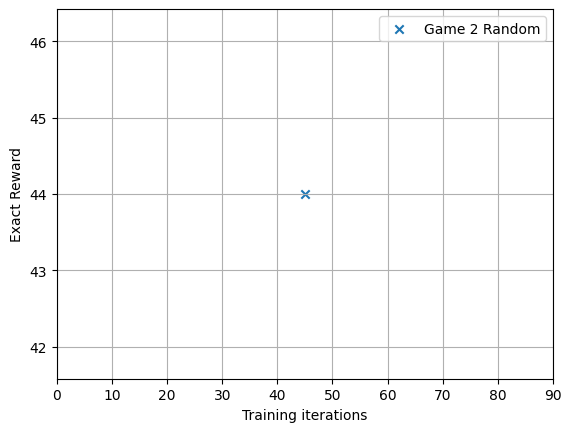

In [17]:
import matplotlib.pyplot as plt
plt.scatter(ep_num, rewards, label="Game 2 Random", marker='x')       
plt.xlabel("Training iterations")
plt.ylabel("Exact Reward")
plt.xticks(np.arange(0,100,10))
plt.legend(loc=1)
plt.grid(True)
plt.show()